In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import pandas as pd
import os
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut
from imblearn.over_sampling import SMOTE, ADASYN
#from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import random
import pickle

## XGB wide search + corr thershold, 2 features sets

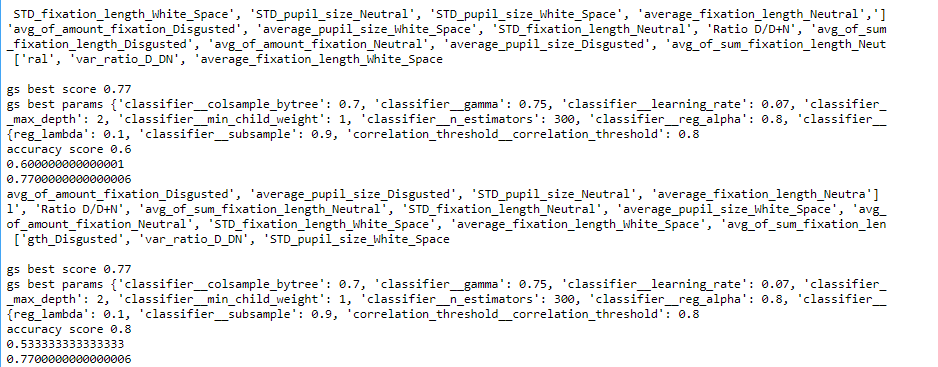

In [30]:
class RemoveCorrelationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, correlation_threshold=0.7):
        self.correlation_threshold = correlation_threshold


    def fit(self, X, Y=None):
        df = pd.DataFrame(X)
        df_corr = df.corr(method='pearson', min_periods=1)
        df_not_correlated = ~(df_corr.mask(
            np.tril(np.ones([len(df_corr)] * 2, dtype=bool))).abs() > self.correlation_threshold).any()
        self.un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
        return self

    def transform(self, X, Y=None):
        df = pd.DataFrame(X)
        df = df[self.un_corr_idx]
        return df.values

In [31]:

class RemoveCorrelationTransformerWithPCA(BaseEstimator, TransformerMixin):
    def __init__(self, correlation_threshold=0.7, pca_components_ratio=3):
        self.correlation_threshold = correlation_threshold
        self.pca_components_ratio = pca_components_ratio


    def fit(self, X, Y=None):
        df = pd.DataFrame(X)
        df_corr = df.corr(method='pearson')
        df_corr = df_corr - np.eye(df.shape[1])
        outliares_corr = df_corr[np.abs(df_corr) > self.correlation_threshold]
        self.outliares_corr = outliares_corr.dropna(axis=1, how='all')

        correlated_df = df[self.outliares_corr.columns]

        n_components = len(self.outliares_corr.columns) // self.pca_components_ratio
        pca = PCA(n_components=n_components)

        correlated_df = pca.fit_transform(correlated_df)
        self.correlated_df = pd.DataFrame(correlated_df, columns=["pca_{}".format(i) for i in range(n_components)])

        return self

    def transform(self, X, Y=None):
        df = pd.DataFrame(X)
        df = df.drop((self.outliares_corr.columns), axis=1)
        df = df.join(self.correlated_df)
        return df

In [32]:
class RemoveMissingFeaturesTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, Y=None):
        self.is_missing = X.isnull().values.any(axis=0)
        return self

    def transform(self, X, Y=None):
        copy_x = pd.DataFrame(X)
        self.is_missing += copy_x.isnull().values.any(axis=0)

        copy_x = copy_x.iloc[:, ~self.is_missing]

        return copy_x.values


In [43]:
def refactor_labels(df):
    return df.replace({'low': 0 ,'high': 1, 'clinical': 1 })


def get_data(file_name, LSAS_threshold=None):
    group_column = 'group'
    sub_num_col = 'Subject_Number'
    lsas_col = 'LSAS'
    df = pd.read_excel(file_name, sheet_name='Sheet1')
    if LSAS_threshold is None:
        X = df.drop([group_column, sub_num_col, lsas_col], 1)
        Y = refactor_labels(df[group_column])
        return X, Y
    else:
        X = df.drop([group_column], 1)
        Y = pd.Series(np.where(X[lsas_col] > LSAS_threshold, 1, 0))
        X = X.drop([sub_num_col, lsas_col], 1)
        return X, Y


In [44]:
#from random features copy 7
features_lists_ = [
['avg_of_sum_fixation_length_Disgusted', 'STD_pupil_size_All', 'STD_fixation_length_All', 'average_pupil_size_All', 'average_pupil_size_White_Space', 'avg_of_sum_fixation_length_White_Space', 'average_fixation_length_White_Space', 'STD_fixation_length_White_Space', 'avg_of_amount_fixation_Neutral', 'mean_different_AOI_per_trial', 'Ratio N/D+N', 'average_pupil_size_Disgusted'],
['average_fixation_length_White_Space', 'STD_fixation_length_White_Space', 'avg_of_sum_fixation_length_White_Space', 'avg_of_amount_fixation_Neutral', 'STD_pupil_size_All', 'STD_fixation_length_All', 'mean_different_AOI_per_trial', 'average_pupil_size_White_Space', 'average_pupil_size_All', 'avg_of_sum_fixation_length_Disgusted', 'Ratio N/D+N', 'average_pupil_size_Disgusted'],
['STD_fixation_length_All', 'mean_different_AOI_per_trial', 'average_fixation_length_White_Space', 'average_pupil_size_Disgusted', 'avg_of_amount_fixation_Neutral', 'average_pupil_size_All', 'Ratio N/D+N', 'avg_of_sum_fixation_length_Disgusted', 'STD_pupil_size_All', 'average_pupil_size_White_Space', 'avg_of_sum_fixation_length_White_Space', 'STD_fixation_length_White_Space'],
['average_fixation_length_White_Space', 'Ratio N/D+N', 'STD_fixation_length_White_Space', 'average_pupil_size_White_Space', 'average_pupil_size_All', 'STD_fixation_length_All', 'avg_of_amount_fixation_Neutral', 'average_pupil_size_Disgusted', 'avg_of_sum_fixation_length_White_Space', 'avg_of_sum_fixation_length_Disgusted', 'STD_pupil_size_All', 'mean_different_AOI_per_trial'],
['STD_pupil_size_All', 'STD_fixation_length_White_Space', 'average_pupil_size_All', 'STD_fixation_length_All', 'average_pupil_size_White_Space', 'avg_of_amount_fixation_Neutral', 'avg_of_sum_fixation_length_White_Space', 'Ratio N/D+N', 'mean_different_AOI_per_trial', 'average_fixation_length_White_Space', 'average_pupil_size_Disgusted', 'avg_of_sum_fixation_length_Disgusted'],
['avg_of_sum_fixation_length_Disgusted', 'STD_fixation_length_All', 'Ratio N/D+N', 'STD_fixation_length_White_Space', 'mean_different_AOI_per_trial', 'STD_pupil_size_All', 'avg_of_sum_fixation_length_White_Space', 'average_fixation_length_White_Space', 'avg_of_amount_fixation_Neutral', 'average_pupil_size_Disgusted', 'average_pupil_size_All', 'average_pupil_size_White_Space'],
['STD_pupil_size_All', 'STD_fixation_length_All', 'Ratio N/D+N', 'STD_fixation_length_White_Space', 'avg_of_sum_fixation_length_Disgusted', 'average_pupil_size_White_Space', 'mean_different_AOI_per_trial', 'avg_of_amount_fixation_Neutral', 'average_pupil_size_Disgusted', 'average_fixation_length_White_Space', 'avg_of_sum_fixation_length_White_Space', 'average_pupil_size_All'],
['STD_fixation_length_All', 'avg_of_sum_fixation_length_White_Space', 'avg_of_sum_fixation_length_Disgusted', 'STD_pupil_size_All', 'avg_of_amount_fixation_Neutral', 'mean_different_AOI_per_trial', 'average_pupil_size_All', 'average_fixation_length_White_Space', 'average_pupil_size_White_Space', 'average_pupil_size_Disgusted', 'Ratio N/D+N', 'STD_fixation_length_White_Space'],
['STD_fixation_length_White_Space', 'Ratio N/D+N', 'STD_pupil_size_All', 'average_fixation_length_White_Space', 'average_pupil_size_All', 'avg_of_amount_fixation_Neutral', 'STD_fixation_length_All', 'average_pupil_size_White_Space', 'avg_of_sum_fixation_length_White_Space', 'avg_of_sum_fixation_length_Disgusted', 'average_pupil_size_Disgusted', 'mean_different_AOI_per_trial'],
['mean_different_AOI_per_trial', 'average_fixation_length_White_Space', 'average_pupil_size_White_Space', 'avg_of_amount_fixation_Neutral', 'STD_fixation_length_White_Space', 'avg_of_sum_fixation_length_White_Space', 'STD_fixation_length_All', 'average_pupil_size_Disgusted', 'avg_of_sum_fixation_length_Disgusted', 'Ratio N/D+N', 'average_pupil_size_All', 'STD_pupil_size_All'],
['average_pupil_size_All', 'Ratio N/D+N', 'STD_pupil_size_All', 'avg_of_sum_fixation_length_White_Space', 'STD_fixation_length_White_Space', 'avg_of_sum_fixation_length_Disgusted', 'STD_fixation_length_All', 'avg_of_amount_fixation_Neutral', 'average_pupil_size_Disgusted', 'mean_different_AOI_per_trial', 'average_pupil_size_White_Space', 'average_fixation_length_White_Space'],
    
]

## get training data

In [45]:
file_name = "training_set_100_updated.xlsx"
X_full_training_set, y_full_training_set = get_data(file_name, LSAS_threshold = 50)
random.seed(217828)

In [46]:
pipe =  Pipeline([
        ('correlation_threshold', RemoveCorrelationTransformer()), 
    ('classifier', XGBClassifier())])

In [47]:
params_grid = [
    {
       'correlation_threshold__correlation_threshold' : [0.8, 1],
        'classifier__max_depth': [3, 2 ,6],
        'classifier__learning_rate': [0.1, 0.05, 0.15],
        'classifier__n_estimators': [100,200, 300]}] 

In [48]:
def split_data(feature_set, X_full_training_set, y_full_training_set):
    columns_shuffled = list(feature_set)
    random.shuffle(columns_shuffled)
    X_full_training_set = X_full_training_set[columns_shuffled] 
    X_train, X_holdout, y_train, y_holdout = train_test_split(X_full_training_set, y_full_training_set, 
                                                              test_size = 0.1, stratify=y_full_training_set)
    return X_train, X_holdout, y_train, y_holdout

In [49]:
def check_over_k_runs(k, cv,  X, y, best_estimator_):
    results = []
    
    for i in range(k):
        score = cross_val_score(best_estimator_, X, y, cv=cv)
        results.append(score.mean())
        
    print(sum(results)/k)
    return (sum(results)/k)

In [50]:
def check_generalization(pipe, params_grid, X_train, X_full_training_set, X_holdout,
                         y_train, y_full_training_set, y_holdout, k=100):
    
    cv = LeaveOneOut()#StratifiedKFold(10)
    gs = GridSearchCV(pipe, params_grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    print("gs best score", gs.best_score_)
    print("gs best params", gs.best_params_)
    
    model = gs.best_estimator_.fit(X_train, y_train)
    y_pred = model.predict(X_holdout)
    holdout_acc = accuracy_score(y_pred, y_holdout)
    print("accuracy score", holdout_acc)
    
    taining_set_cv = check_over_k_runs(k, LeaveOneOut(),  X_train, y_train, gs.best_estimator_)
    full_set_cv = check_over_k_runs(k, LeaveOneOut(),  X_full_training_set, y_full_training_set, gs.best_estimator_)
    model = gs.best_estimator_.fit(X_full_training_set, y_full_training_set)
    save_model(holdout_acc, taining_set_cv, full_set_cv, model)

In [51]:
def save_model(holdout_acc, taining_set_cv, full_set_cv, model):
    if (holdout_acc >= 0.6) & (taining_set_cv >= 0.6) & (full_set_cv > 0.75):
        print("saving model")
        filename = "finalized_model_copy_10.pkl"
        pickle.dump(model, open(filename, 'wb'))


In [52]:
for feature_set in features_lists_:
    print (feature_set, "\n")
    
    X_train, X_holdout, y_train, y_holdout = split_data(feature_set, X_full_training_set, y_full_training_set)
    check_generalization(pipe,  params_grid, X_train, X_full_training_set, X_holdout,
                         y_train, y_full_training_set, y_holdout)
    

['avg_of_sum_fixation_length_Disgusted', 'STD_pupil_size_All', 'STD_fixation_length_All', 'average_pupil_size_All', 'average_pupil_size_White_Space', 'avg_of_sum_fixation_length_White_Space', 'average_fixation_length_White_Space', 'STD_fixation_length_White_Space', 'avg_of_amount_fixation_Neutral', 'mean_different_AOI_per_trial', 'Ratio N/D+N', 'average_pupil_size_Disgusted'] 

gs best score 0.7777777777777778
gs best params {'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__n_estimators': 200, 'correlation_threshold__correlation_threshold': 1}
accuracy score 0.5
0.7777777777777771
0.6499999999999991
['average_fixation_length_White_Space', 'STD_fixation_length_White_Space', 'avg_of_sum_fixation_length_White_Space', 'avg_of_amount_fixation_Neutral', 'STD_pupil_size_All', 'STD_fixation_length_All', 'mean_different_AOI_per_trial', 'average_pupil_size_White_Space', 'average_pupil_size_All', 'avg_of_sum_fixation_length_Disgusted', 'Ratio N/D+N', 'average_pupil_size_

KeyboardInterrupt: 